# Refinement test

In [1]:
import Pkg                             #hide
Pkg.activate(joinpath(@__DIR__, "..")) #hide
Pkg.resolve(io=devnull)                #hide

  Activating project at `~/Software/EqFlux/doc/examples`


In this tutorial, we use the estimator obtained by the equilibrated flux
to drive an adative mesh refinement (AMR) procedure.
We consider the Laplace problem
$$\begin{align}
-\Delta u &= 0 &&\text{ in }\Omega\\
u &= g &&\text{ on }\partial\Omega
\end{align}$$
on an L-shaped domain $\Omega = (-1,1)^2 \setminus [(0,1)\times(-1,0)]$.
We load this domain from a json file.

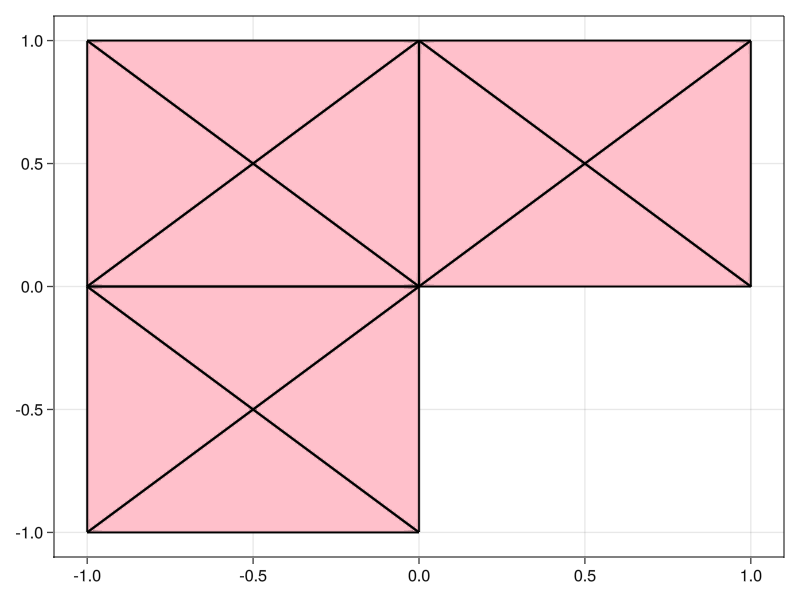

In [2]:
using Gridap
model = DiscreteModelFromFile("Lshaped.json")
Ω = Triangulation(model)
using GridapMakie, GLMakie
fig = plot(Ω)
wireframe!(Ω, color=:black, linewidth=2);
fig

In this case, we know the true solution $u$
is given by the following formula in polar coordinates:

In [3]:
"Have to convert from -[π, π] to [0, 2π]"
function θ(x)
  θt = atan(x[2], x[1])
  (θt >= 0) * θt + (θt < 0) * (θt + 2 * π)
end

r(x) = sqrt(x[1]^2 + x[2]^2)

α = 2 / 3

u(x) = r(x)^α * sin(θ(x) * α)
u_fig, _ , plt = plot(Ω, u, colormap=:viridis)
Colorbar(u_fig[1,2], plt)

Colorbar()

In [4]:
using Gridap
using Gridap.Geometry
using Gridap.Adaptivity
using EqFlux

We define some helper functions for computing the L² norm in Gridap

In [5]:
L2_inner_product(f, g, dx) = ∫(f ⋅ g) * dx

L2_norm_squared(f, dx) = L2_inner_product(f, f, dx)

function L2_norm_squared(f, model, order)
  degree = 2 * order + 2
  Ω = Triangulation(model)
  dx = Measure(Ω, degree)
  L2_norm_squared(f, dx)
end

L2_norm_squared (generic function with 2 methods)

Next, we define the Dörfler marking[1]

In [6]:
function dorfler_marking(η_arr)
  if η_arr isa Gridap.Arrays.LazyArray
    η_arr = EqFlux.smart_collect(η_arr)
  end
  θ = 0.3 # Marking parameter
  η_tot = sum(η_arr)
  sorted_inds = sortperm(η_arr, rev = true)
  sorted = η_arr[sorted_inds]
  η_partial = 0.0
  i = 1
  while η_partial <= θ * η_tot
    η_partial += sorted[i]
    i += 1
  end
  sorted_inds[1:i]
end

dorfler_marking (generic function with 1 method)

As a small example, we show the result of calling
`dorfler_marking

This step just corresponds to the contents of the [first Gridap.jl tutorial](https://gridap.github.io/Tutorials/dev/pages/t001_poisson/#Tutorial-1:-Poisson-equation-1).

In [7]:
function solve_laplace(model, order, g)
  Ω = Triangulation(model)
  degree = 2 * order + 2
  dx = Measure(Ω, degree)
  a(u, v) = ∫(∇(v) ⊙ ∇(u)) * dx
  b(v) = ∫(v * 0.0) * dx
  reffe = ReferenceFE(lagrangian, Float64, order)
  V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = "boundary")
  U = TrialFESpace(V0, g)
  op = AffineFEOperator(a, b, U, V0)
  uh = solve(op)
  dofs = num_free_dofs(V0)
  uh, dx, dofs
end

solve_laplace (generic function with 1 method)

This function uses the EqFlux.jl package to obtain an error estimation on each cell
of the mesh.

In [8]:
function estimate_laplace(uh, dx, model, order)
    σ = build_equilibrated_flux(-∇(uh), x -> 0.0, model, order)
    #σ = build_averaged_flux(∇(uh), model)
    η² = L2_norm_squared(σ + ∇(uh), dx)
    Ω = Triangulation(model)
    getindex(η², Ω)
  end

using Gridap.Adaptivity

Finally, this function puts the previous functions together into the standard
Solve -> Estimate -> Mark -> Refine
loop of AFEM. The refinement step using newest vertex bisection can
be selected using "nvb" with the keyword argument refinement_method.
g is the function on the Dirichlet boundary.

In [9]:
function solve_estimate_mark_refine_laplace(model, tol, order; g)
  η = Inf
  estimators = Float64[]
  errors = Float64[]
  num_dofs = Float64[]
  error_fields = CellField[]
  while η > tol
    # We extract the internal model from the refined model
    if model isa AdaptedDiscreteModel
      model = model.model
    end
    # SOLVE
    uh, dx, dofs = solve_laplace(model, order, g)
    push!(num_dofs, dofs)
    # ESTIMATE
    η_arr = estimate_laplace(uh, dx, model, order)
    H1err² = L2_norm_squared(∇(u - uh), dx)
    Ω = Triangulation(model)
    error_field = CellField(sqrt.(getindex(H1err², Ω)), Ω)
    push!(error_fields, error_field)
    H1err = √sum(H1err²)
    η = √(sum(η_arr))
    push!(estimators, η)
    push!(errors, H1err)
    # MARK
    cells_to_refine = dorfler_marking(η_arr)
    # REFINE
    model = refine(model, refinement_method = "nvb", cells_to_refine = cells_to_refine)

  end
  return error_fields, num_dofs, estimators, errors
end

solve_estimate_mark_refine_laplace (generic function with 1 method)

We can change the polynomial order here as well as the tolerance for the
estimator.

In [10]:
order = 2
tol = 1e-4

0.0001

We pass the true solution as the Dirichlet function $g$

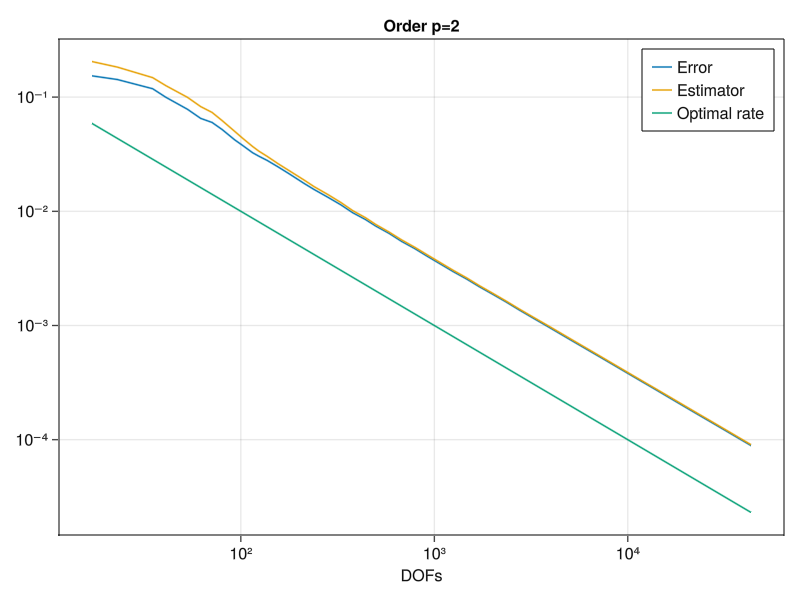

In [11]:
error_fields, num_dofs, estimators, errors = solve_estimate_mark_refine_laplace(model, tol, order, g = u)
fig = Figure()
axis = Axis(fig[1,1], xscale = log10, yscale = log10, title = "Order p=$order", xlabel = "DOFs")
lines!(axis, num_dofs, errors, label = "Error")
lines!(axis, num_dofs, estimators, label = "Estimator")
lines!(axis, num_dofs, num_dofs.^(-order / 2), label = "Optimal rate")
axislegend()
fig

We now show that the AFEM refinement achieves the optimat rate of convergence
of $\mathrm{DOFs}^{-p/d} = \mathrm{DOFs}^{-p/2}$ in 2D.

In [12]:
@show estimators[end]

estimators[end] = 9.03958981149896e-5


9.03958981149896e-5

Finally, we plot a .gif that shows sequence of meshes generated by the
adaptive refinement procedure. The refinement is clearly concentrated to the
re-entrant corner.

In [13]:
idx = Observable(1)
errors_plot = lift(idx) do idx
  error_fields[idx].trian
end

fig, ax, plt = plot(errors_plot)
#display(fig)
wireframe!(errors_plot, color=:black, linewidth=2)
framerate = 5
idxs = 1:length(error_fields)
record(fig, "animation.gif", idxs; framerate=framerate, compression=0) do this_idx
  idx[] = this_idx
end

"animation.gif"

![](animation.gif)

In [14]:
#wireframe!(Ω, color=:black, linewidth=2);

[1] Dörfler, W. A convergent adaptive algorithm for Poisson’s equation. SIAM Journal on Numerical
Analysis 33, 3 (1996), 1106–1124

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*